In [95]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import copy
from keras.models import load_model
from skimage.segmentation import clear_border

In [96]:
ls

'path_to_save_weights (1).h5'   sample_data/   sudoku.jpg


## Board and Character Recognition

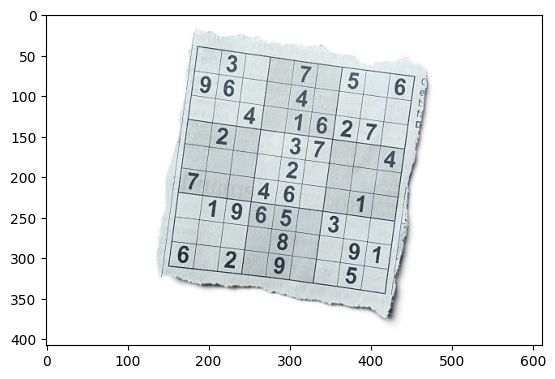

In [109]:
image = cv2.imread('/content/sudoku.jpg')
plt.imshow(image)

In [110]:
def four_point_transform1(img, location, height = 900, width = 900):
    plt.imshow(img)
    plt.show()
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts1 = pts1.astype(np.float32)
    pts2  = pts2.astype(np.float32)
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

In [111]:
def find_board(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   # blurred = cv2.GaussianBlur(gray, (7, 7), 3)
    thresh = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#     edges = cv2.Canny(blurred, 50, 150)
#     cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    puzzleCnt = None

    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if our approximated contour has four points, then we can
        # assume we have found the outline of the puzzle
        if len(approx) == 4:
            puzzleCnt = approx
            break
    if puzzleCnt is None:
        raise Exception(("Could not find Sudoku puzzle outline. "
        "Try debugging your thresholding and contour steps."))
    warped = four_point_transform1(gray, puzzleCnt.reshape(4, 2))
    return warped

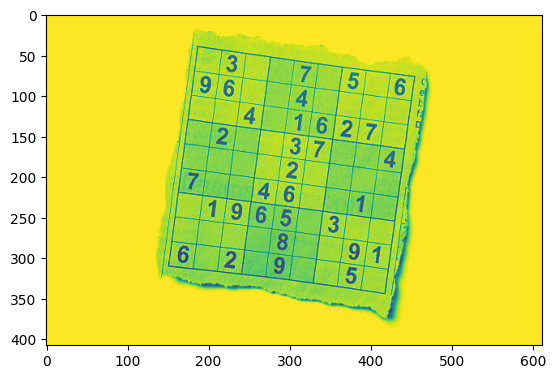

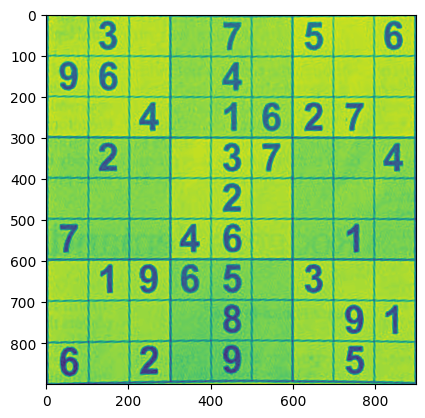

In [112]:
img= find_board(image)
#plt.imshow(loc,cmap='gray')
plt.imshow(img)

In [113]:
def split_boxes(board,input_size=28):
    rows = np.vsplit(board,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [114]:
boxes = split_boxes(img)

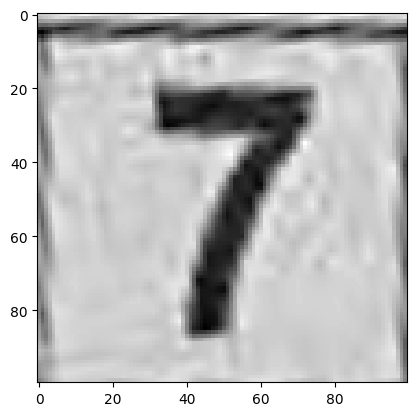

In [115]:
plt.imshow(boxes[4],cmap='gray')

In [116]:
model=load_model('/content/path_to_save_weights (1).h5')

In [117]:
def extract_digit(cell, debug=False):
    cell = np.uint8(cell)
    thresh = cv2.threshold(cell, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
#     if debug:
#         cv2.imshow("Cell Thresh", thresh)
# 		cv2.waitKey(0)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return (None,False)
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)
    if percentFilled < 0.03:
        return (None,False)
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
#     if debug:
# 		cv2.imshow("Digit", digit)
# 		cv2.waitKey(0)
	# return the digit to the calling function
    return (digit,True)
def print_grid(arr):
    for i in range(9):
        for j in range(9):
            print (arr[i][j], end = " "),
        print ()


In [118]:
grid = [[0 for _ in range(9)] for _ in range(9)]
for i in range(9):
  for j in range(9):
    if extract_digit(boxes[9*i+j])[1]==False:
      grid[i][j]=0
    else:
      print("hello")
      grid[i][j]= np.argmax(model.predict(cv2.resize(extract_digit(boxes[9*i+j])[0],(28,28)).reshape(1,28,28,1)))
print_grid(grid)


hello
1/1 [==============================] - 0s 70ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 17ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 31ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 36ms/step
hello
1/1 [==============================] - 0s 37ms/step
hello
1/1 [==============================] - 0s 29ms/step
hello
1/1 [==============================] - 0s 37ms/step
hello
1/1 [==============================] - 0s 45ms/step
hello
1/1 [==============================] - 0s 30ms/step
hello
1/1 [==============================] - 0s 27ms/step
hello
1/1 [===

In [119]:
def print_grid(arr):
    for i in range(9):
        for j in range(9):
            print (arr[i][j], end = " "),
        print ()

def find_empty_location(arr, l):
    for row in range(9):
        for col in range(9):
            if(arr[row][col]== 0):
                l[0]= row
                l[1]= col
                return True
    return False

def used_in_row(arr, row, num):
    for i in range(9):
        if(arr[row][i] == num):
            return True
    return False

def used_in_col(arr, col, num):
    for i in range(9):
        if(arr[i][col] == num):
            return True
    return False

def used_in_box(arr, row, col, num):
    for i in range(3):
        for j in range(3):
            if(arr[i + row][j + col] == num):
                return True
    return False

def check_location_is_safe(arr, row, col, num):
    return (not used_in_row(arr, row, num) and
           (not used_in_col(arr, col, num) and
           (not used_in_box(arr, row - row % 3,
                           col - col % 3, num))))
def solve_sudoku(arr):
    l =[0, 0]
    if(not find_empty_location(arr, l)):
        return True
    row = l[0]
    col = l[1]
    for num in range(1, 10):
        if(check_location_is_safe(arr,row, col, num)):
            arr[row][col]= num
            if(solve_sudoku(arr)):
                return True
            arr[row][col] = 0

    return False

In [120]:
if(solve_sudoku(grid)==False):
  print("Sudoku problem is wrong")
else:
   print("Successfully solved")
   print_grid(grid)

Sudoku problem is wrong
